# 1. Import the Packages

In [1]:
# Standard Python libraries
import os
import random
import time
from datetime import datetime
import subprocess

# Libraries for data manipulation and visualization
import cv2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Libraries for detection and classification
from mtcnn import MTCNN 
from keras_facenet import FaceNet
import joblib
from sklearn.model_selection import StratifiedKFold
from sklearn import svm
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, classification_report
from sklearn.preprocessing import LabelEncoder

# 2. Dataset Aquisition

Capturing data set for new user from camera

In [2]:
def captureImage():
    # Ask the user if they want to use the existing dataset or capture new images
    use_existing_data = input("Do you want to add a new dataset (y/n)? ")

    if use_existing_data.lower() == 'n':
        # Break from the function
        return

    if use_existing_data.lower() == 'y':
        # Run the _DATASET-UTK-TA.py script
        subprocess.run(["python", "D:\KULIAH\TUGAS AKHIR\THE PROJECT\.coding capture dataset sementara\Smart-Absensi-main\_DATASET-UTK-TA.py"])

captureImage()

# 3. Preprocessing Image

### 3.1. MTCNN Part

Extract faces from captured image using MTCNN and resize the image into 160x160. After that, do flip and contrast stretching to resized image

In [3]:
class FACELOADING:
    def __init__(self, directory):
        self.directory = directory
        self.target_size = (160, 160)
        self.X = []
        self.Y = []
        self.detector = MTCNN()

    def extract_faces(self, filename):
        img = cv2.imread(filename)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        hasil_deteksi = self.detector.detect_faces(img)

        # Getting x, y, w, h from image 'box'
        x, y, w, h = hasil_deteksi[0]['box']
        x, y, w, h = abs(x), abs(y), abs(w), abs(h)

        # Draw rectangle box on detected face
        img = cv2.rectangle(img, (x, y), (x+w, y+h), (0, 0, 255), 10)

        wajah = img[y:y + h, x:x + w]
        wajah_arr = cv2.resize(wajah, self.target_size)
        return wajah_arr

    def load_faces(self, dir, class_label):
        FACES = []
        Y = []
        for im_name in os.listdir(dir):
            try:
                path = os.path.join(dir, im_name)
                single_face = self.extract_faces(path)
                FACES.append(single_face)
                Y.append(class_label)

            except Exception as e:
                pass
        return FACES, Y

    def parse_filename(self, filename):
        # Mengambil NIM dan Nama dari nama file dengan pola "NIM_Nama_i.jpg"
        nim, nama, _ = filename.split('_')
        return nim, nama

    def load_classes_after_augmentation(self, output_folder=None):
        # Inisialisasi kembali X dan Y
        X = []
        Y = []

        # Membuat subdirektori yang belum ada
        if output_folder:
            for class_label in set(self.Y):  # Menggunakan set(Y) untuk mendapatkan kelas unik
                class_dir = os.path.join(output_folder, class_label)
                if not os.path.exists(class_dir):
                    os.makedirs(class_dir)

        for sub_dir in os.listdir(self.directory):
            path = os.path.join(self.directory, sub_dir)
            FACES, labels = self.load_faces_after_augmentation(path, sub_dir, output_folder=output_folder)
            X.extend(FACES)
            Y.extend(labels)

        return X, Y

    def load_faces_after_augmentation(self, dir, class_label, output_folder=None):
        FACES = []
        Y = []
        for i, im_name in enumerate(os.listdir(dir)):
            try:
                path = os.path.join(dir, im_name)
                single_face = self.extract_faces(path)
                FACES.append(single_face)
                Y.append(class_label)

                nim, nama = self.parse_filename(im_name)

                # Check if the output folder exists for the current class label
                class_output_folder = os.path.join(output_folder, class_label)
                if not os.path.exists(class_output_folder):
                    os.makedirs(class_output_folder)    

                # Jika ingin melakukan augmentasi pada citra di sini, tambahkan proses augmentasi di sini.
                flipped_face = cv2.flip(single_face, 1)  # 1 for horizontal flip
                FACES.append(flipped_face)
                Y.append(class_label)

                contrast_stretched_face = self.contrast_stretching(single_face)
                FACES.append(contrast_stretched_face)
                Y.append(class_label)

                grayscale_face = cv2.cvtColor(single_face, cv2.COLOR_RGB2GRAY)
                grayscale_face = cv2.cvtColor(grayscale_face, cv2.COLOR_GRAY2RGB)
                FACES.append(grayscale_face)
                Y.append(class_label)

                if output_folder:
                    index_start = 1 + i * 4

                    # Simpan citra dengan penamaan yang mengikuti nim dan nama
                    original_filename = f"{nim}_{nama}_{index_start}.jpg"
                    output_path_original = os.path.join(output_folder, class_label, original_filename)
                    cv2.imwrite(output_path_original, cv2.cvtColor(single_face, cv2.COLOR_RGB2BGR))

                    flipped_filename = f"{nim}_{nama}_{index_start + 1}.jpg"
                    output_path_flip = os.path.join(output_folder, class_label, flipped_filename)
                    cv2.imwrite(output_path_flip, cv2.cvtColor(flipped_face, cv2.COLOR_RGB2BGR))

                    stretched_filename = f"{nim}_{nama}_{index_start + 2}.jpg"
                    output_path_stretch = os.path.join(output_folder, class_label, stretched_filename)
                    cv2.imwrite(output_path_stretch, cv2.cvtColor(contrast_stretched_face, cv2.COLOR_RGB2BGR))

                    grayscale_filename = f"{nim}_{nama}_{index_start + 3}.jpg"
                    output_path_grayscale = os.path.join(output_folder, class_label, grayscale_filename)
                    cv2.imwrite(output_path_grayscale, cv2.cvtColor(grayscale_face, cv2.COLOR_RGB2BGR))

            except Exception as e:
                pass
        return FACES, Y

    def contrast_stretching(self, image):
        # Compute minimum and maximum pixel values for each channel
        min_val = np.min(image, axis=(0, 1))
        max_val = np.max(image, axis=(0, 1))

        # Perform contrast stretching for each channel
        stretched = (image - min_val) * (255.0 / (max_val - min_val))
        stretched = np.clip(stretched, 0, 255).astype(np.uint8)

        return stretched

In [4]:
# Ask the user if they want to use the existing dataset or capture new images
use_existing_data = input("Do you want to use the last existing dataset (y/n)? ")
faces_dataset_filename = "dataframe_and_model_files/loadedfaces.npz"

# If the user wants to use the existing dataset, load the dataset from the .pkl file
if use_existing_data.lower() == 'y':
    # Loads the faces and labels from the compressed .npz file.
    loaded_data = np.load("dataframe_and_model_files/loadedfaces.npz")
    X = loaded_data["X"]
    Y = loaded_data["Y"]

    print(f"Faces Dataset successfully loaded from {faces_dataset_filename}")
    print(f"===============================================")

    print(f"Unique Labels After Augmentation: {set(Y)}")
    print(f'Total Images in Array After Augmentation: {len(X)} images')

if use_existing_data.lower() == 'n':
    # Gunakan kelas FACELOADING dengan folder direktori "capturedfaces"
    face_loader = FACELOADING("capturedfaces")
    X, Y = face_loader.load_classes_after_augmentation(output_folder="datawajah")

    print(f"Unique Labels After Augmentation: {set(Y)}")
    print(f'Total Images in Array After Augmentation: {len(X)} images')

    # Saves the loaded faces and labels into a compressed .npz file
    np.savez_compressed(faces_dataset_filename, X=X, Y=Y)

    print()
    print("File loaded and saved to dataframe_and_model_files/loadedfaces.npz")

Faces Dataset successfully loaded from dataframe_and_model_files/loadedfaces.npz
Unique Labels After Augmentation: {'rizky-mahesa-ramadhan', 'zidan-nuryawan-pratomo', 'ismail-nurhapid-jamal', 'siti-bilqis', 'shabrina-katresnawati', 'vito-mulia-febiansyah', 'rizky-nurhadhi', 'rahayu-puspitasari', 'muhammad-tegar-heidar-gunawan'}
Total Images in Array After Augmentation: 3600 images


Creating dataframe that containing available images from extracted faces and checking total files in the folder

In [5]:
def create_dataframe():
    # Initialize main dataset folder
    dataset_folder = "datawajah"
    root_folder = dataset_folder

    data = []
  
    # Iterate through the main folder and subfolders
    for root, dirs, files in os.walk(root_folder):
        for file in files:
        # Get the subfolder name (classes)
            classes = os.path.basename(root)

            # Get the full path of the image
            image_path = os.path.join(classes, file)

            # Add data to the list
            data.append({'Classes': classes, 'File Name': file, 'Image Path': image_path})

    # Create a dataframe from the data list
    df = pd.DataFrame(data)

    # Save the dataframe to an Excel file
    excel_file_name = 'dataframe_and_model_files/faces_train_data.xlsx'
    df.to_excel(excel_file_name, index=False)

    print("Dataframe successfully saved to", excel_file_name)

    return df

In [6]:
def total_images_per_class(df):
    # Function to calculate the total number of files in a folder.
    def total_file(classes):
        return len(df[df['Classes'] == classes].values)

    # Iterate through unique classes and print the total number of files for each class
    unique_classes = df['Classes'].unique()
    print("Total number of images in each class :")
    for classes in unique_classes:
        count = total_file(classes)
        print(f"'{classes}': {count} images")

In [7]:
# Create the dataframe
df = create_dataframe()

# Calculate and print the total number of images in each class
total_images_per_class(df)

Dataframe successfully saved to dataframe_and_model_files/faces_train_data.xlsx
Total number of images in each class :
'ismail-nurhapid-jamal': 400 images
'muhammad-tegar-heidar-gunawan': 400 images
'rahayu-puspitasari': 400 images
'rizky-mahesa-ramadhan': 400 images
'rizky-nurhadhi': 400 images
'shabrina-katresnawati': 400 images
'siti-bilqis': 400 images
'vito-mulia-febiansyah': 400 images
'zidan-nuryawan-pratomo': 400 images


In [8]:
df.sample(10)

,Classes,File Name,Image Path
2717,siti-bilqis,1207070117_SITI BILQIS_385.jpg,siti-bilqis\1207070117_SITI BILQIS_385.jpg
3529,zidan-nuryawan-pratomo,1207070132_ZIDAN NURYAWAN P_396.jpg,zidan-nuryawan-pratomo\1207070132_ZIDAN NURYAW...
2421,siti-bilqis,1207070117_SITI BILQIS_118.jpg,siti-bilqis\1207070117_SITI BILQIS_118.jpg
2991,vito-mulia-febiansyah,1207070126_VITO MULIA FEBIANSYAH_271.jpg,vito-mulia-febiansyah\1207070126_VITO MULIA FE...
2380,shabrina-katresnawati,1207070136_SHABRINA KATRESNAWATI_81.jpg,shabrina-katresnawati\1207070136_SHABRINA KATR...
2906,vito-mulia-febiansyah,1207070126_VITO MULIA FEBIANSYAH_195.jpg,vito-mulia-febiansyah\1207070126_VITO MULIA FE...
629,muhammad-tegar-heidar-gunawan,1207070080_MUHAMMAD TEGAR HEIDAR GUNAWAN_305.jpg,muhammad-tegar-heidar-gunawan\1207070080_MUHAM...
3336,zidan-nuryawan-pratomo,1207070132_ZIDAN NURYAWAN P_221.jpg,zidan-nuryawan-pratomo\1207070132_ZIDAN NURYAW...
3325,zidan-nuryawan-pratomo,1207070132_ZIDAN NURYAWAN P_211.jpg,zidan-nuryawan-pratomo\1207070132_ZIDAN NURYAW...
2683,siti-bilqis,1207070117_SITI BILQIS_354.jpg,siti-bilqis\1207070117_SITI BILQIS_354.jpg


### 3.2. FaceNet Part

Embed the dataset to 512 dimension image (1x1x512) and save it into .npz file

In [9]:
embedder = FaceNet()

def get_embedding(face_image):
    face_image = face_image.astype('float32') # 3D(160x160x3)
    face_image = np.expand_dims(face_image, axis=0) # 4D(Nonex160x160x3)
    
    yhat = embedder.embeddings(face_image)

    return yhat[0] #512D image (1x1x128)

In [10]:
embedded_data_loaded = input("Do you want to load last saved embedded data from the file 'dataframe_and_model_files/embedded_dataset.npz' (y/n)? ")
embedded_file_name = "dataframe_and_model_files/embedded_dataset.npz"

if embedded_data_loaded.lower() == 'y':
    # Load the embedded data from the npz file
    loaded_data = np.load('dataframe_and_model_files/embedded_dataset.npz', allow_pickle=True)
    EMBEDDED_X = loaded_data['arr_0']
    Y = loaded_data['arr_1']

    # # Reload the arrays of original X
    loaded_data = np.load("dataframe_and_model_files/loadedfaces.npz")
    X = loaded_data["X"]

    print(f"Embedded dataset successfully loaded from {embedded_file_name}")
    print()
    print(f"Unique Labels: {set(Y)}")
    print(f'Total Embedded Images in Array: {len(EMBEDDED_X)}')
    
if embedded_data_loaded.lower() == 'n':
    # Embedding the datasets and save it to the npz file
    EMBEDDED_X = []
    
    for face_image in X:
        EMBEDDED_X.append(get_embedding(face_image))
        
    EMBEDDED_X = np.asarray(EMBEDDED_X)
    np.savez_compressed(embedded_file_name, EMBEDDED_X, Y)  
    print("Embedded dataset successfully saved to", embedded_file_name)
    print("===============================================")
    print(f"Unique Labels: {set(Y)}")
    print(f'Total Embedded Images in Array: {len(EMBEDDED_X)}')

1/1 [==============================] - 0s 60ms/step
Embedded dataset successfully saved to dataframe_and_model_files/embedded_dataset.npz
Unique Labels: {'rizky-mahesa-ramadhan', 'zidan-nuryawan-pratomo', 'ismail-nurhapid-jamal', 'siti-bilqis', 'shabrina-katresnawati', 'vito-mulia-febiansyah', 'rizky-nurhadhi', 'rahayu-puspitasari', 'muhammad-tegar-heidar-gunawan'}
Total Embedded Images in Array: 3600


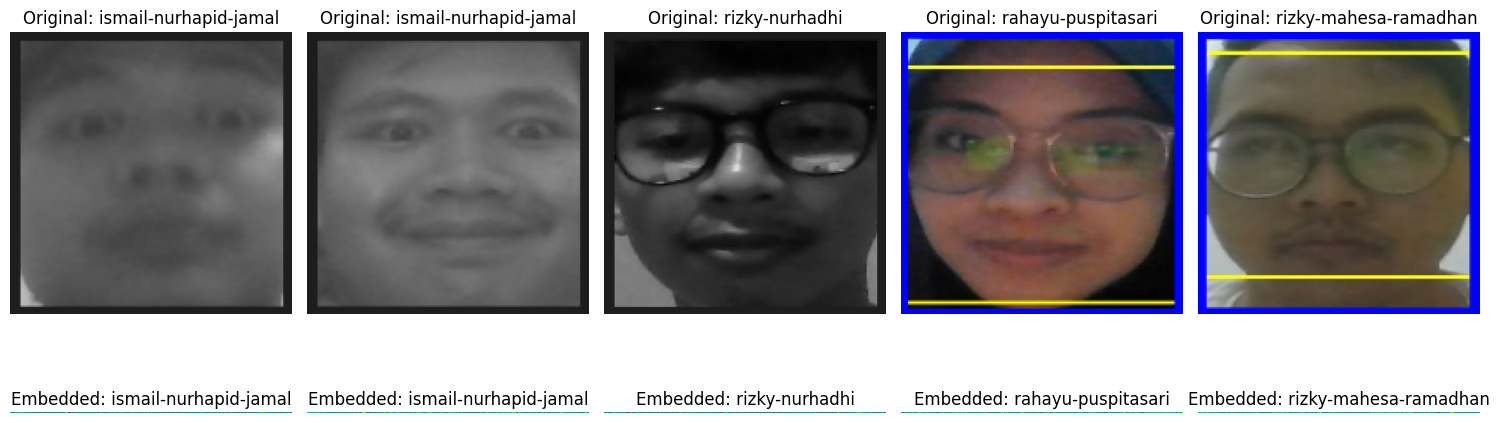

In [11]:
# Choose a few random indices
num_display_samples = 5
sample_indices = random.sample(range(len(EMBEDDED_X)), min(num_display_samples, len(EMBEDDED_X)))

# Display the sample images with their corresponding labels and embeddings
plt.figure(figsize=(15, 6))
for i, index in enumerate(sample_indices):
    plt.subplot(2, num_display_samples, i + 1)
    plt.imshow(X[index])
    plt.title(f"Original: {Y[index]}")
    plt.axis('off')

    plt.subplot(2, num_display_samples, i + num_display_samples + 1)
    plt.imshow(EMBEDDED_X[index].reshape((1, -1)))
    plt.title(f"Embedded: {Y[index]}")
    plt.axis('off')

plt.tight_layout()

In [12]:
# Check correspondence between images in 'X' and labels in 'Y'
for i in range(len(X)):
    print(f"Label: {Y[i]}, File Name: {df['File Name'].iloc[i]}")

Label: ismail-nurhapid-jamal, File Name: 1207070060_ISMAIL NURHAPID JAMAL_1.jpg
Label: ismail-nurhapid-jamal, File Name: 1207070060_ISMAIL NURHAPID JAMAL_10.jpg
Label: ismail-nurhapid-jamal, File Name: 1207070060_ISMAIL NURHAPID JAMAL_100.jpg
Label: ismail-nurhapid-jamal, File Name: 1207070060_ISMAIL NURHAPID JAMAL_101.jpg
Label: ismail-nurhapid-jamal, File Name: 1207070060_ISMAIL NURHAPID JAMAL_102.jpg
Label: ismail-nurhapid-jamal, File Name: 1207070060_ISMAIL NURHAPID JAMAL_103.jpg
Label: ismail-nurhapid-jamal, File Name: 1207070060_ISMAIL NURHAPID JAMAL_104.jpg
Label: ismail-nurhapid-jamal, File Name: 1207070060_ISMAIL NURHAPID JAMAL_105.jpg
Label: ismail-nurhapid-jamal, File Name: 1207070060_ISMAIL NURHAPID JAMAL_106.jpg
Label: ismail-nurhapid-jamal, File Name: 1207070060_ISMAIL NURHAPID JAMAL_107.jpg
Label: ismail-nurhapid-jamal, File Name: 1207070060_ISMAIL NURHAPID JAMAL_108.jpg
Label: ismail-nurhapid-jamal, File Name: 1207070060_ISMAIL NURHAPID JAMAL_109.jpg
Label: ismail-nurha

## 4. SVM Classification

### 4.1. Checking Labelling of Images

In [13]:
Y

array(['ismail-nurhapid-jamal', 'ismail-nurhapid-jamal',
       'ismail-nurhapid-jamal', ..., 'zidan-nuryawan-pratomo',
       'zidan-nuryawan-pratomo', 'zidan-nuryawan-pratomo'], dtype='<U29')

In [14]:
encoder = LabelEncoder()
encoder.fit(Y)
Y = encoder.transform(Y)

Y

array([0, 0, 0, ..., 8, 8, 8])

### 4.2. K-Fold Cross Validation and SVM Classification

Metrics calculation from this fold:
Accuracy Test: 100.00% || Precision: 100.00% || Recall: 100.00% || F1 score: 100.00%

Metrics calculation from this fold:
Accuracy Test: 100.00% || Precision: 100.00% || Recall: 100.00% || F1 score: 100.00%

Metrics calculation from this fold:
Accuracy Test: 100.00% || Precision: 100.00% || Recall: 100.00% || F1 score: 100.00%

Metrics calculation from this fold:
Accuracy Test: 100.00% || Precision: 100.00% || Recall: 100.00% || F1 score: 100.00%

Metrics calculation from this fold:
Accuracy Test: 100.00% || Precision: 100.00% || Recall: 100.00% || F1 score: 100.00%

Metrics calculation from this fold:
Accuracy Test: 100.00% || Precision: 100.00% || Recall: 100.00% || F1 score: 100.00%

Metrics calculation from this fold:
Accuracy Test: 100.00% || Precision: 100.00% || Recall: 100.00% || F1 score: 100.00%

Metrics calculation from this fold:
Accuracy Test: 100.00% || Precision: 100.00% || Recall: 100.00% || F1 score: 100.00%

Metrics calculation from

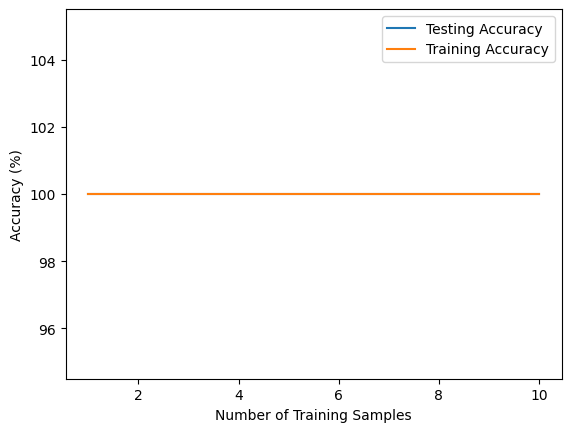

In [15]:
# Load the data from the npz file
loaded_data = np.load('dataframe_and_model_files/embedded_dataset.npz', allow_pickle=True)
X = loaded_data['arr_0']
Y = loaded_data['arr_1']

encoder = LabelEncoder()
encoder.fit(Y)
Y = encoder.transform(Y)

# Initialize Stratified K-Fold CV
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# Empty list to store predicted and truth values from all folds
expedted_y = []
predicted_y = []

# Initialize lists to store the metrics for all folds
accuracy_scores = []
precision_scores = []
recall_scores = []
f1_scores = []
accuracy_stratified = []

# Fit and predict iteratively on all splits
for train_index, test_index in skf.split(X, Y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = Y[train_index], Y[test_index]

    # Initialize SVM model and fit the data
    model = svm.SVC(kernel='linear', C=1, probability=True, random_state=42)
    model.fit(X_train, y_train)

    # Print accuracy for each fold
    ypred_test = model.predict(X_test)
    ypred_train = model.predict(X_train)

    # Calculate the metrics for this fold
    accuracy = accuracy_score(y_test, ypred_test)*100
    precision = precision_score(y_test, ypred_test, average='weighted')*100
    recall = recall_score(y_test, ypred_test, average='weighted')*100
    f1 = f1_score(y_test, ypred_test, average='weighted')*100

    accuracy_scores.append(accuracy)
    precision_scores.append(precision)
    recall_scores.append(recall)
    f1_scores.append(f1)

    # Print the metrics for this fold
    print("Metrics calculation from this fold:")
    print(f"Accuracy Test: {accuracy:.2f}% || Precision: {precision:.2f}% || Recall: {recall:.2f}% || F1 score: {f1:.2f}%")
    print()
    
    # Store the prediction into the list
    predicted_y.extend(ypred_test)

    # Store truth value for this predicted fold
    expedted_y.extend(y_test)

# Mean accuracy from all folds
accuracy = accuracy_score(expedted_y, predicted_y)*100
print("=====================================")
print(f"Accuracy from all folds : {accuracy:.2f}%")

# Plot the learning curve
plt.plot(range(1, len(accuracy_scores) + 1), accuracy_scores, label='Testing Accuracy')
plt.plot(range(1, len(accuracy_scores) + 1), [accuracy_score(y_train, model.predict(X_train))*100 for _ in range(len(accuracy_scores))], label='Training Accuracy')
plt.xlabel('Number of Training Samples')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.show()

### 4.3. Saving Model to .pkl Files

In [16]:
# Save the model
model_name = 'dataframe_and_model_files/svm_model_classifier.pkl'
joblib.dump(model, model_name)
print(f"Model is successfully saved to {model_name}")

Model is successfully saved to dataframe_and_model_files/svm_model_classifier.pkl


### 4.4. Model Evaluation Confusion Matrix

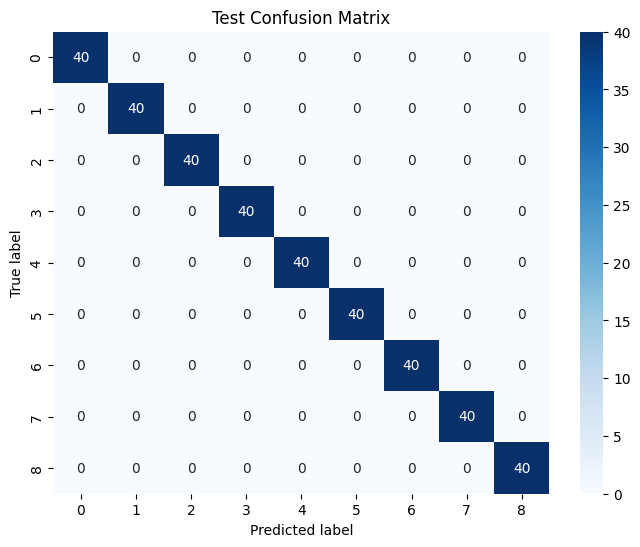

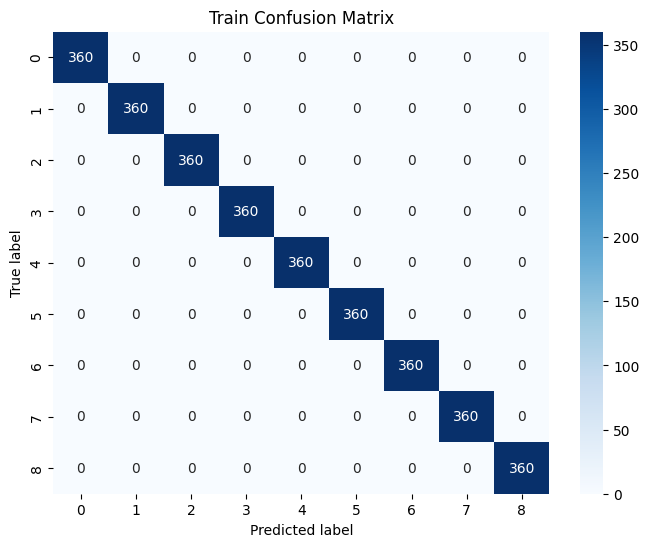

In [17]:
# Plot test confusion matrix
cm_test = confusion_matrix(y_true=y_test, y_pred=ypred_test)
plt.figure(figsize=(8,6))
sns.heatmap(cm_test, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Test Confusion Matrix')
plt.show()

# Plot train confusion matrix
cm_train = confusion_matrix(y_true=y_train, y_pred=ypred_train)
plt.figure(figsize=(8,6))
sns.heatmap(cm_train, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Train Confusion Matrix')
plt.show()

### 4.5. Model Recognition Testing using Camera

In [18]:
loaded_actual_embedding = "dataframe_and_model_files\embedded_dataset.npz"
model_name = 'dataframe_and_model_files/svm_model_classifier.pkl'
loaded_model = joblib.load(model_name)
detector = MTCNN()
embedder = FaceNet()

# Load the actual embeddings from the embedded_dataset.npz file
with np.load(loaded_actual_embedding) as data:
    X_embedded, y_embedded = data['arr_0'], data['arr_1']

# Creating a dictionary that maps the class numbers to their corresponding label strings
class_dict = dict(enumerate(encoder.classes_))

# Add a 5-second delay
# time.sleep(5)

# Open the camera
cap = cv2.VideoCapture(0)

# Capture 30 frames
frames = []
counter = 1
while len(frames) < 30:
    ret, frame = cap.read()
    if counter >= 10:
        frames.append(frame)
    counter += 1

# Release the camera
cap.release()

# Create the scannedfaces folder if it doesn't exist
if not os.path.exists('scannedfaces'):
    os.makedirs('scannedfaces')

# Initialize a counter for the frame name
frame_counter = 1

# Initialize a set to store unique face labels
unique_faces = set()

# Process each frame in the frames list
for frame in frames:
    # Detect faces in the frame
    faces = detector.detect_faces(frame)

    # Extract the detected faces as 160x160 RGB images
    extracted_faces = []
    for face in faces:
        x, y, w, h = face['box']
        face_image = frame[y:y+h, x:x+w]
        face_image = cv2.resize(face_image, (160, 160))
        face_image = cv2.cvtColor(face_image, cv2.COLOR_BGR2RGB)
        extracted_faces.append(face_image)

    # Embed the extracted faces using the FaceNet model
    embeddings = []
    for face in extracted_faces:
        embedding = embedder.embeddings(np.array([face]))
        embeddings.append(embedding[0])

    # Predict the embedded faces using the model
    faces_predicted = []
    for embedding in embeddings:
        ypred = loaded_model.predict_proba(embedding.reshape(1, -1))  # Get probabilities for each class
        label = np.argmax(ypred)  # Find the class with the highest probability
        confidence = ypred[0][label] * 100  # Calculate confidence as a percentage
        faces_predicted.append((label, confidence))

    # Display the original bounding boxes and labels on the frame
    for i, face in enumerate(faces):
        x, y, w, h = face['box']
        cv2.rectangle(frame,(x, y), (x+w, y+h), (255, 255, 0), 2)
        label, confidence = faces_predicted[i]
        display_name = class_dict[label].replace('-', ' ').title()
        if confidence > 65:
            cv2.putText(frame, f"{display_name} ({confidence:.2f}%)", (x, y-10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 0), 2)
            # cv2.putText(frame, f"({confidence:.2f}%)", (x+15, y+h+30), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (255, 255, 0), 2)
            unique_faces.add(display_name)
        else:
            cv2.putText(frame, f"Unknown ({confidence:.2f}%)", (x, y-10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 0), 2)

    # Save the frame to the scannedfaces folder
    cv2.imwrite(f"scannedfaces/frame_{frame_counter}.png", frame)
    frame_counter += 1

# Print the list of unique faces
print("Unique faces recognized:", list(unique_faces))

1/1 [==============================] - 0s 60ms/step
Unique faces recognized: ['Rizky Nurhadhi']
